In [ ]:
# load packages for association rules
!pip3 install fpgrowth_py

# import libraries
from fpgrowth_py import fpgrowth
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns # 
%matplotlib inline
import time
import datetime as dt



Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
#Read csv
data = pd.read_csv('/content/data.csv', encoding = "ISO-8859-1") # import data
df = data 
df['GroupPrice']=df['Quantity']*df['UnitPrice']
df=df.dropna() # drop null values
print('The dimensions of the dataset are : ', df.shape)
print('---------')
df.head()
#Rename column for InvoiceNo and CustomerID
df = df.rename(columns = {'InvoiceNo': 'Invoice No'})
df = df.rename(columns = {'CustomerID': 'Customer ID'})

The dimensions of the dataset are :  (406829, 9)
---------


In [ ]:
#Products that match gifts offered to customers by the company are removed from sale. Only the items that the customer has actually added to his shopping basket are kept.
sto_uniq= df['StockCode'].unique() 
stock_to_del=[]
for xl in sto_uniq:
    if xl[0] not in ['1','2','3','4','5','6','7','8','9','10']: # Check products corresponding to gifts. 
        stock_to_del.append(xl)

df=df[df['StockCode'].map(lambda x: x not in stock_to_del)] # delete these products by checking them

GroupedBasket = df.groupby(['Invoice No','Customer ID']).agg({'StockCode': lambda s: list(set(s))}) # grouping products that comes from the same invoice. 

print('Dimension of the new grouped dataset : ', GroupedBasket.shape)
print('----------')
df.head()

Dimension of the new grouped dataset :  (21788, 1)
----------


,Invoice No,StockCode,Description,Quantity,InvoiceDate,UnitPrice,Customer ID,Country,GroupPrice
0,541431,23166,MEDIUM CERAMIC TOP STORAGE JAR,74215,1/18/2011 10:01,1.04,12346.0,United Kingdom,77183.6
1,C541433,23166,MEDIUM CERAMIC TOP STORAGE JAR,-74215,1/18/2011 10:17,1.04,12346.0,United Kingdom,-77183.6
2,537626,85116,BLACK CANDELABRA T-LIGHT HOLDER,12,12/07/2010 14:57,2.10,12347.0,Iceland,25.2
3,537626,22375,AIRLINE BAG VINTAGE JET SET BROWN,4,12/07/2010 14:57,4.25,12347.0,Iceland,17.0
4,537626,71477,COLOUR GLASS. STAR T-LIGHT HOLDER,12,12/07/2010 14:57,3.25,12347.0,Iceland,39.0


In [ ]:
#Association rules using fpgrowth
Starttime=time.time()
freqItemSet, rules = fpgrowth(GroupedBasket['StockCode'].values, minSupRatio=0.005, minConf=0.3)
Endtime=time.time()
print('Execution time in seconds : ',Endtime-Starttime, ' s.')
print('Number of rules generated : ', len(rules))

associationrules=pd.DataFrame(rules,columns =['GroupedBasket','next_product','proba']) 
associationrules=associationrules.sort_values(by='proba',ascending=False)
print('Dimensions of the associationrules table are : ', associationrules.shape)
associationrules.head(10)

Execution time in seconds :  364.9052197933197  s.
Number of rules generated :  4955
Dimensions of the associationrules table are :  (4955, 3)


,GroupedBasket,next_product,proba
201,"{22917, 22921, 22920, 22916, 22919}",{22918},0.992537
422,"{22921, 22919, 22917, 22916}",{22918},0.986014
307,"{22921, 22917, 22916, 22920}",{22918},0.985714
306,"{22921, 22918, 22917, 22920}",{22916},0.985714
93,"{22921, 22919, 22917, 22920}",{22918},0.985401
230,"{22921, 22919, 22916, 22920}",{22918},0.985401
200,"{22921, 22920, 22918, 22916, 22919}",{22917},0.985185
199,"{22917, 22921, 22920, 22918, 22919}",{22916},0.985185
365,"{22921, 22917, 22916}",{22918},0.979866
456,"{22921, 22919, 22917}",{22918},0.979730


In [ ]:
#Function to compute next best product to each customer
def computenextbest_product(GroupedBasket_el):
    """
    parameter : GroupedBasket_el = list of consumer GroupedBasket elements
    return : next_pdt, proba = next product to recommend, buying probability. Or (0,0) if no product is found. 
            
    
    Description : If a product was not discovered in the list of associations of the table connected to the FP Growth model, it is returned to the customer's basket with a recommendation.
                  To achieve this, we look for the product to recommend from each individual product in the shopper's basket in the table of associations.
    
    """
    
    for k in GroupedBasket_el: # for each element in the consumer GroupedBasket
            k={k}
            if len(associationrules[associationrules['GroupedBasket']==k].values) !=0: # if we find a corresponding associationrules in the fp growth table
                next_pdt=list(associationrules[associationrules['GroupedBasket']==k]['next_product'].values[0])[0] # we take the consequent product
                if next_pdt not in GroupedBasket_el : # We verify that the customer has not previously purchased the product
                    proba=associationrules[associationrules['GroupedBasket']==k]['proba'].values[0] # Find the associated probability. 
                    return(next_pdt,proba)
    
    return(0,0) # return (0,0) if no product was found. 

In [ ]:
#Function to find best product for each customer
def findnext_product(GroupedBasket):
    """
    Parameter : GroupedBasket = consumer GroupedBasket dataframe
    Return : list_nextproducts, list_probability = list of next elements to recommend and the buying probabilities associated.
    
    Description : Main function of the aforementioned. We search the Fp Growth model table for corresponding association rules for each customer in the dataset. In the absence of any association rules, the computenextbest product function is used, which looks for specific product association rules. If no individual ssociations are found, the function returns (0,0).
    
    """
    n=GroupedBasket.shape[0]
    list_nextproducts=[]
    list_probability=[]
    for i in range(n): # for each customer
        xl=set(GroupedBasket['StockCode'][i]) # customer's GroupedBasket
        if len(associationrules[associationrules['GroupedBasket']==xl].values) !=0: # if we find a associationrules in the fp growth table corresponding to all the customer's GroupedBasket.
            next_product=list(associationrules[associationrules['GroupedBasket']==xl]['next_product'].values[0])[0] # We take the consequent product
            proba=associationrules[associationrules['GroupedBasket']==xl]['proba'].values[0] # Probability associated in the table
            list_nextproducts.append(next_product)
            list_probability.append(proba)


        elif len(associationrules[associationrules['GroupedBasket']==xl].values) ==0: # If no antecedent to all the GroupedGroupedBasket was found in the table
            next_product,proba= computenextbest_product(GroupedBasket['StockCode'][i]) # previous function
            list_nextproducts.append(next_product)
            list_probability.append(proba)
            
    return(list_nextproducts, list_probability)

In [ ]:
#To compute each customer
Starttime=time.time()
list_nextproducts, list_probability= findnext_product(GroupedBasket) 
Endtime=time.time()
print(Endtime-Starttime)
GroupedBasket['Recommended_Products']=list_nextproducts # Set of Recommended_Products
GroupedBasket['Probability']=list_probability # Set of probabilities associated
GroupedBasket.head()


158.9691755771637


,,StockCode,Recommended_Products,Probability
Invoice No,Customer ID,,,
536365,17850.0,"[84029E, 84029G, 71053, 85123A, 84406B, 22752,...",0,0.000000
536366,17850.0,"[22633, 22632]",22865,0.470982
536367,13047.0,"[22623, 22310, 22745, 22749, 21754, 22748, 217...",22750,0.593516
536368,13047.0,"[22912, 22960, 22913, 22914]",22961,0.322280
536369,13047.0,[21756],21754,0.576132


In [ ]:
#Estimating prices based on given recommendations, displaying the resulting table with the association (customer, product recommended)
GroupedBasket=GroupedBasket.rename(columns = {'StockCode': 'Customer_Basket'})
df_stock=df.drop_duplicates(subset ="StockCode", inplace = False)
prices=[]
description_list=[]
for i in range(GroupedBasket.shape[0]):
    stockcode=GroupedBasket['Recommended_Products'][i]
    probability= GroupedBasket['Probability'][i]
    if stockcode != 0:
        unitprice=df_stock[df_stock['StockCode']==stockcode]['UnitPrice'].values[0]
        description=df_stock[df_stock['StockCode']==stockcode]['Description'].values[0]
        Price_estim=unitprice*probability
        prices.append(Price_estim)
        description_list.append(description)
        
    else :
        prices.append(0)
        description_list.append('Null')

#To assign 2 new variables - price estimation and product description into GroupBasket's dataframe
GroupedBasket['Price_Estimation']=prices 
GroupedBasket['Product_Description']=description_list 
GroupedBasket = GroupedBasket.reindex(columns=['Customer_Basket','Recommended_Products','Product_Description','Probability','Price_Estimation'])
GroupedBasket.head()

,,Customer_Basket,Recommended_Products,Product_Description,Probability,Price_Estimation
Invoice No,Customer ID,,,,,
536365,17850.0,"[84029E, 84029G, 71053, 85123A, 84406B, 22752,...",0,Null,0.000000,0.000000
536366,17850.0,"[22633, 22632]",22865,HAND WARMER OWL DESIGN,0.470982,0.989063
536367,13047.0,"[22623, 22310, 22745, 22749, 21754, 22748, 217...",22750,FELTCRAFT PRINCESS LOLA DOLL,0.593516,2.225686
536368,13047.0,"[22912, 22960, 22913, 22914]",22961,JAM MAKING SET PRINTED,0.322280,0.467306
536369,13047.0,[21756],21754,HOME BUILDING BLOCK WORD,0.576132,3.427984


In [ ]:
#Generate the percentage of anticapation of customer needs with the recommendation system of association rule based on their purchasing history
print('On average, the recommendation system of assocation rule can predict in ',GroupedBasket['Probability'].mean() *100,  '% of the cases the next product that the customer will buy.')

On average, the recommendation system of assocation rule can predict in  35.67279386230027 % of the cases the next product that the customer will buy.


In [ ]:
#Generate turnover rate in Euros
print('With only 1 single product proposed, the recommendation system of association rule can generate a turnover in this case up to : ', round(GroupedBasket['Price_Estimation'].sum()), ' euros.') 

With only 1 single product proposed, the recommendation system of association rule can generate a turnover in this case up to :  20848  euros.


In [ ]:
#RFM Segmentation
#df = pd.read_csv('/content/data.csv', encoding = "ISO-8859-1") # import data
df = df.rename(columns = {'InvoiceNo': 'Invoice No'})
df = df.rename(columns = {'CustomerID': 'Customer ID'})
#copy data into a new dataframe for analysis
df_all= df.copy()

#Calculating the total amount for each line item (unit price * Quantity)
df_all['Total_amount']= df_all['Quantity']* df_all['UnitPrice']
df_all.head()

#Convert InvoiceDate's column to datetime format
df_all['InvoiceDate']=pd.to_datetime(df_all['InvoiceDate'])

#Setting date of analysis= 1 day after the most recent invoice
analysis_date = pd.to_datetime(df_all['InvoiceDate'].max())+ dt.timedelta(days=1)
df_all.head()



,Invoice No,StockCode,Description,Quantity,InvoiceDate,UnitPrice,Customer ID,Country,GroupPrice,Total_amount
0,541431,23166,MEDIUM CERAMIC TOP STORAGE JAR,74215,2011-01-18 10:01:00,1.04,12346.0,United Kingdom,77183.6,77183.6
1,C541433,23166,MEDIUM CERAMIC TOP STORAGE JAR,-74215,2011-01-18 10:17:00,1.04,12346.0,United Kingdom,-77183.6,-77183.6
2,537626,85116,BLACK CANDELABRA T-LIGHT HOLDER,12,2010-12-07 14:57:00,2.10,12347.0,Iceland,25.2,25.2
3,537626,22375,AIRLINE BAG VINTAGE JET SET BROWN,4,2010-12-07 14:57:00,4.25,12347.0,Iceland,17.0,17.0
4,537626,71477,COLOUR GLASS. STAR T-LIGHT HOLDER,12,2010-12-07 14:57:00,3.25,12347.0,Iceland,39.0,39.0


In [ ]:
#To calculate the Recency (R), Frequency (F) and Monetary (M) values for each customer
cust_grouped = df_all.groupby(['Customer ID'])\
                .agg({'InvoiceDate': lambda x: (analysis_date - x.max()).days,
                      'Invoice No': 'count',
                      'Total_amount': 'sum'})\

#To rename each column to for indicating the R,F,M Values
cust_grouped.rename(columns = {'InvoiceDate': 'R_val',
                                   'Invoice No': 'F_val',
                                   'Total_amount': 'M_val'}, inplace=True)
cust_grouped.reset_index().head()

,Customer ID,R_val,F_val,M_val
0,12346.0,326,2,0.00
1,12347.0,2,182,4310.00
2,12348.0,75,27,1437.24
3,12349.0,19,72,1457.55
4,12350.0,310,16,294.40


In [ ]:
#To divide Recency(R) metric into 4 quartiles
r_quartiles = pd.qcut(cust_grouped['R_val'], 4, labels = range(4, 0, -1))
cust_grouped = cust_grouped.assign(R_quartile = r_quartiles.values.astype('int'))

#To divide Frequency(F) metric into 4 quartiles
f_quartiles = pd.qcut(cust_grouped['F_val'], 4, labels = range(1, 5, 1))
cust_grouped = cust_grouped.assign(F_quartile = f_quartiles.values.astype('int'))

#To divide Monetary(M) metric into 4 quartiles
m_quartiles = pd.qcut(cust_grouped['M_val'], 4, labels = range(1, 5, 1))
cust_grouped = cust_grouped.assign(M_quartile = m_quartiles.values.astype('int'))

cust_grouped.head()
cust_grouped.info()

<class 'pandas.core.frame.DataFrame'>
Float64Index: 4363 entries, 12346.0 to 18287.0
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   R_val       4363 non-null   int64  
 1   F_val       4363 non-null   int64  
 2   M_val       4363 non-null   float64
 3   R_quartile  4363 non-null   int64  
 4   F_quartile  4363 non-null   int64  
 5   M_quartile  4363 non-null   int64  
dtypes: float64(1), int64(5)
memory usage: 238.6 KB


In [ ]:
#To obtain RFM segment via concatenation of R,F,M values
cust_grouped['RFM_Segment']=cust_grouped['R_quartile'].astype('str') + cust_grouped['F_quartile'].astype('str') + cust_grouped['M_quartile'].astype('str')

#To count RFM by summing up R,F,M values
cust_grouped['RFM_Score']= cust_grouped[['R_quartile','F_quartile','M_quartile']].sum(axis=1)
cust_grouped.head()

,R_val,F_val,M_val,R_quartile,F_quartile,M_quartile,RFM_Segment,RFM_Score
Customer ID,,,,,,,,
12346.0,326,2,0.00,1,1,1,111,3
12347.0,2,182,4310.00,4,4,4,444,12
12348.0,75,27,1437.24,2,2,3,223,7
12349.0,19,72,1457.55,3,3,3,333,9
12350.0,310,16,294.40,1,1,2,112,4


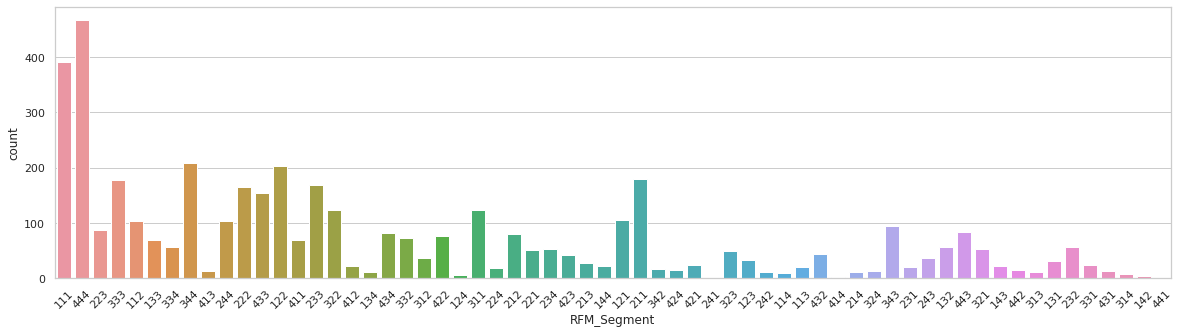

In [ ]:
#Visualization of the total count of each RFM Segment:
#set sns theme
sns.set_theme(style="whitegrid")

#Set plot size
fig, ax = plt.subplots(figsize=(20, 5))

#Plot count of each RFM segment
sns.countplot(x="RFM_Segment", data=cust_grouped)
plt.xticks(rotation=45)

plt.show()

In [ ]:
#Function for grouping the customers into different tiers based on their total RFM Score
def get_cust_tier(a):
    if a >9:
        return 'Platinum'
    elif (a>6) & (a<=9):
        return 'Gold'
    elif (a>3) & (a<=6):
        return 'Silver'
    elif (a>0) & (a<=3):
        return 'Bronze' 

#Assign a tier to each customer based on the get_cust_tier function logic
cust_grouped['Tier']=cust_grouped['RFM_Score'].apply(get_cust_tier)
cust_grouped.head()

,R_val,F_val,M_val,R_quartile,F_quartile,M_quartile,RFM_Segment,RFM_Score,Tier
Customer ID,,,,,,,,,
12346.0,326,2,0.00,1,1,1,111,3,Bronze
12347.0,2,182,4310.00,4,4,4,444,12,Platinum
12348.0,75,27,1437.24,2,2,3,223,7,Gold
12349.0,19,72,1457.55,3,3,3,333,9,Gold
12350.0,310,16,294.40,1,1,2,112,4,Silver


In [ ]:
#To compute the mean of the R-F-M values of each tier and also their counts.
df_reset= cust_grouped.reset_index()
tier_analysis=df_reset.groupby(['Tier'])\
        .agg({'R_val': 'mean',
                      'F_val': 'mean',
                      'M_val': 'mean'}).round(2)
print(tier_analysis,'\n')
print(cust_grouped['Tier'].value_counts())

           R_val   F_val    M_val
Tier                             
Bronze    265.59    7.95   130.92
Gold       63.14   57.75  1000.93
Platinum   19.10  231.12  4975.65
Silver    138.83   21.40   391.48 

Silver      1370
Gold        1319
Platinum    1282
Bronze       392
Name: Tier, dtype: int64


In [ ]:
#To look up total customers in each country
country_count=df_all.groupby(['Country']).size().to_frame('Total_Customers_in_country').reset_index()
country_count.head()

#To merge with original df for adding the 'Country' column
df_with_country = df_reset.merge(df_all[['Customer ID','Country']], how='inner', on='Customer ID')
result= df_with_country.groupby(['Tier','Country']).size().to_frame('Customer_count').reset_index()
country_data= result.merge(country_count, how='inner', on='Country')

#To filter dataset for Basic Tier
basic_tier= country_data[country_data['Tier'].isin(['Bronze'])]

#To calculate percentage of Basic Tier customers in each country
basic_tier['Bronze_Tier_Percentage']= ((basic_tier['Customer_count']/basic_tier['Total_Customers_in_country'])*100)\
                                           .round(3)
#To display top 5 countries with the largest percentage of Basic Tier Customers
basic_tier[['Country', 'Bronze_Tier_Percentage']].sort_values('Bronze_Tier_Percentage', ascending=False).head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,Country,Bronze_Tier_Percentage
41,Saudi Arabia,100.000
4,Bahrain,23.529
10,Canada,6.667
13,Cyprus,1.939
29,Italy,1.916


In [ ]:
#To filter dataset for Platinum Tier
platinum_tier= country_data[country_data['Tier'].isin(['Platinum'])]

#To calculate the percentage of Platinum Tier customers in each country
platinum_tier['Platinum_Tier_Percentage']= ((platinum_tier['Customer_count']/platinum_tier['Total_Customers_in_country'])*100)\
                                            .round(3)
#To display top 5 countries with the largest percentage of Platinum Tier Customers
platinum_tier[['Country','Platinum_Tier_Percentage']].sort_values('Platinum_Tier_Percentage', ascending=False).head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


,Country,Platinum_Tier_Percentage
96,Singapore,100.000
95,Iceland,100.000
61,EIRE,97.818
35,Netherlands,91.330
51,Australia,84.487
